## This notebook calculates and evaluates the total impact of the displaced lepton systematic.

First we extract the lepton d0 values. Since it should not matter what type of signal the lepton comes from, 
this method combines all muons in one collection and all electrons in another. 
The denominator is defined as all leptons, regardless of quality. 
The numerator is the same collection of leptons but with quality cuts applied (VeryVeryLoose for electrons and Medium for muons).

In [23]:
import sys
sys.path.append('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/dhnlplotting/util')

import glob
import os
from plot_base import PlotBase
from IPython.display import display, Image
import ROOT
ROOT.gROOT.SetStyle("ATLAS")
from array import array
import importlib
import plot_base
import plot_util
import numpy as np
importlib.reload(plot_base)
importlib.reload(plot_util)

# ____________________________________________________________
# Get histograms

displaced_lepton_syst_d0_bins = [0, 3, 10, 20, 30, 40, 50, 60]
bins = array('f', displaced_lepton_syst_d0_bins)
nbins = len(bins) - 1
overflow_bin = nbins + 1

try:
    for obj_name in ["h_abs_d0_all_el", "h_abs_d0_selected_el", "h_abs_d0_all_mu", "h_abs_d0_selected_mu"]:
        ROOT.gROOT.FindObject(obj_name).Delete()
except:
    pass

el_denom = ROOT.TH1F("h_abs_d0_all_el","All electrons", nbins, bins) 
el_num = ROOT.TH1F("h_abs_d0_selected_el","Selected Electrons", nbins, bins) 
mu_denom = ROOT.TH1F("h_abs_d0_all_mu","All muons", nbins, bins) 
mu_num = ROOT.TH1F("h_abs_d0_selected_mu","Selected muons", nbins, bins) 

trees = []

var_name = 'd0'
# var_name = 'd0_truth'

for filename in glob.glob('/data/hnl/histograms/v5p0_histograms/histograms_mc16a_*.root'):
    for f in [
        filename, 
        filename.replace('mc16a', 'mc16d'), 
        filename.replace('mc16a', 'mc16e'), 
        ]: 
        if var_name == 'd0_truth' and 'mc16a' in f:
            continue # Truth d0 is NAN for mc16a for some reason. Causes overflow issues.
        if not os.path.isfile(f):
            print('missing', f)
            continue
        tfile = ROOT.TFile(f)
        tfile.cd()
        trees.append(tfile)

        for treename in ['VSI_LeptonsMod_ntuples_LNV_DVtype', 'VSI_LeptonsMod_ntuples_LNC_DVtype']:
            tree = tfile.Get(treename)
            trees.append(tree)

            # denom
            abs_d0_all_lep0 = ROOT.TH1F("h_abs_d0_all_lep0","h_abs_d0_all_lep0", nbins, bins)
            tree.Draw(f"abs(DV_trk_0_{var_name})>>h_abs_d0_all_lep0","", "")
            abs_d0_all_lep1 = ROOT.TH1F("h_abs_d0_all_lep1","h_abs_d0_all_lep1", nbins, bins)
            tree.Draw(f"abs(DV_trk_1_{var_name})>>h_abs_d0_all_lep1","", "")

            # both are muons
            if 'uuu' in f: 
                mu_denom.Add(abs_d0_all_lep0)
                mu_denom.Add(abs_d0_all_lep1)
                quality_requirement_0 = 'DV_lep_0_muon_isMedium>=1'
                quality_requirement_1 = 'DV_lep_1_muon_isMedium>=1'

            # both are electrons
            if 'eee' in f: 
                el_denom.Add(abs_d0_all_lep0)
                el_denom.Add(abs_d0_all_lep1)
                quality_requirement_0 = 'DV_lep_0_electron_VeryVeryLoose>=1'
                quality_requirement_1 = 'DV_lep_1_electron_VeryVeryLoose>=1'

            if 'uue' in f or 'eeu' in f: # in mixed DVs
                mu_denom.Add(abs_d0_all_lep0) # lep0 is always the muon
                el_denom.Add(abs_d0_all_lep1) # lep1 is always the electron
                quality_requirement_0 = 'DV_lep_0_muon_isMedium>=1'
                quality_requirement_1 = 'DV_lep_1_electron_VeryVeryLoose>=1'

            # num
            abs_d0_sel_lep0 = ROOT.TH1F("h_abs_d0_sel_lep0", "h_abs_d0_sel_lep0", nbins, bins) 
            tree.Draw(f"abs(DV_trk_0_{var_name})>>h_abs_d0_sel_lep0", quality_requirement_0, "")
            abs_d0_sel_lep1 = ROOT.TH1F("h_abs_d0_sel_lep1", "h_abs_d0_sel_lep1", nbins, bins)
            tree.Draw(f"abs(DV_trk_1_{var_name})>>h_abs_d0_sel_lep1", quality_requirement_1, "")

            if 'uuu' in f:
                mu_num.Add(abs_d0_sel_lep0)
                mu_num.Add(abs_d0_sel_lep1)
            if 'eee' in f:
                el_num.Add(abs_d0_sel_lep0)
                el_num.Add(abs_d0_sel_lep1)
            if 'uue' in f or 'eeu' in f: 
                mu_num.Add(abs_d0_sel_lep0) 
                el_num.Add(abs_d0_sel_lep1)

            ROOT.gROOT.FindObject("h_abs_d0_sel_lep0").Delete()
            ROOT.gROOT.FindObject("h_abs_d0_sel_lep1").Delete()
            ROOT.gROOT.FindObject("h_abs_d0_all_lep0").Delete()
            ROOT.gROOT.FindObject("h_abs_d0_all_lep1").Delete()
        # for treename
        tfile.Close()
    # for f
    # break
# for filename

print(el_num, el_num.GetEntries())
print(mu_num, mu_num.GetEntries())
print(el_denom, el_denom.GetEntries())
print(mu_denom, mu_denom.GetEntries())

# move overflow content into last visible bin
for h in [el_denom, el_num, mu_denom, mu_num]:
    # print( h[overflow_bin-1], '+', h[overflow_bin])
    h.SetBinContent(overflow_bin-1, h[overflow_bin-1] + h[overflow_bin])
    h.SetBinContent(overflow_bin, 0)  



Name: h_abs_d0_selected_el Title: Selected Electrons NbinsX: 7 119590.0
Name: h_abs_d0_selected_mu Title: Selected muons NbinsX: 7 192356.0
Name: h_abs_d0_all_el Title: All electrons NbinsX: 7 134872.0
Name: h_abs_d0_all_mu Title: All muons NbinsX: 7 201244.0


This class uses the plotting infrastructure to create nice atlas-style plots to show the systematic.
The ratio histogram is normalized so the first bin is equal to 1 (since we trust this bin has similar values for data and MC).

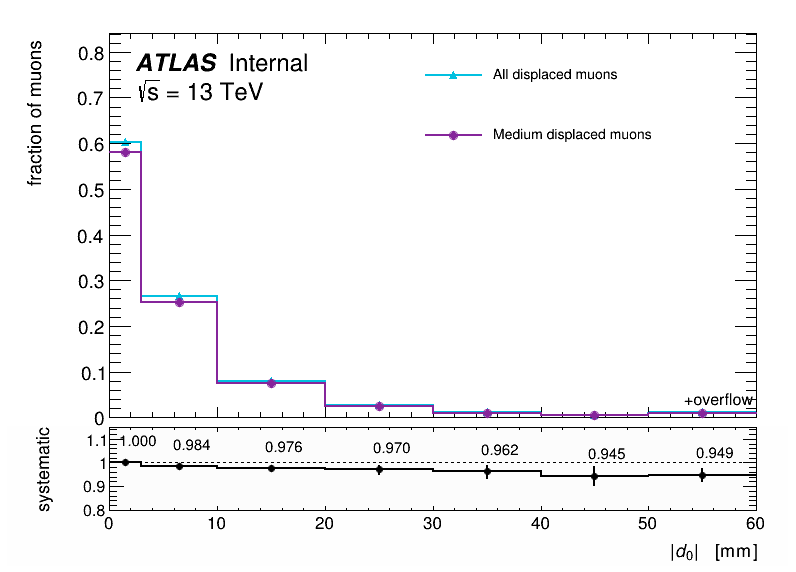

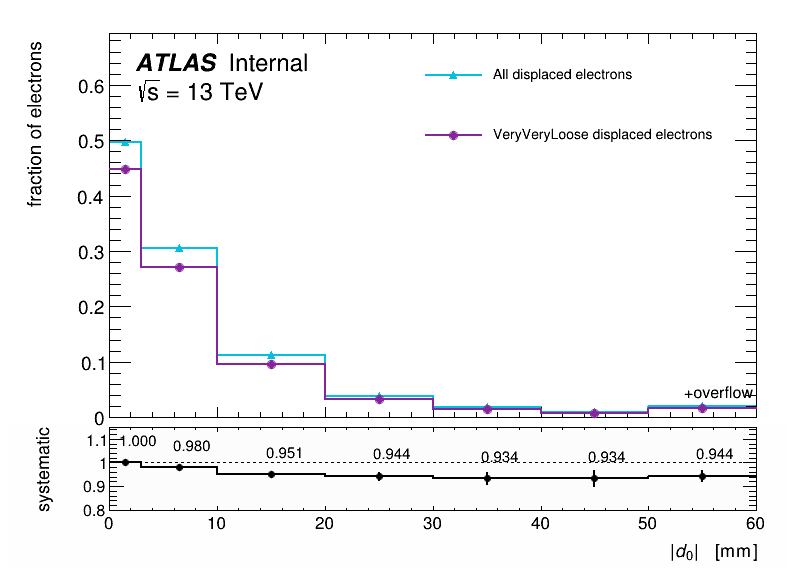

Info in <TCanvas::Print>: png file /home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/displaced_lepton_systematic/png//d0_muon.png has been created
Info in <TCanvas::Print>: eps file /home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/displaced_lepton_systematic/eps//d0_muon.eps has been created
Info in <TCanvas::Print>: png file /home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/displaced_lepton_systematic/png//d0_electron.png has been created
Info in <TCanvas::Print>: eps file /home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/displaced_lepton_systematic/eps//d0_electron.eps has been created


In [27]:
# ____________________________________________________________
# define plotting class

class Hist1DRatio(PlotBase):
    def __init__(self, num, denom, lepton, **kwargs):
        super(Hist1DRatio, self).__init__(
            legend_loc = [0.52, 0.71, 0.92, 0.92],
            atlas_loc = [0.17, 0.875],
            extra_lines_loc = [0.17,0.775],
            x_title = '\ |d_0|',
            x_units = 'mm',
            norm = 1,
            )

        # Get histograms (need to return file too because ROOT is ... ROOT)
        # num, denom = get_histograms(filename, lepton)

        self.hists = [num, denom]
        self.lepton = lepton
        self.pad_empty_space(self.hists)
        self.ratio_ymin = 0.8
        self.ratio_ymax = 1.15
        purple = ROOT.TColor().GetColor("#86259B")
        blue = ROOT.TColor().GetColor("#01C0E0")
        self.colors = [purple, blue]
        self.markers = [20, 22]
        
        # self.extra_legend_lines = [lepton]
        self._make_decorations()
        self.y_title = f'fraction of {lepton}s'

        self.set_titles(num)
        self.set_titles(denom)

        for i, h in enumerate(self.hists):
            h.SetMarkerColor( self.colors[i] )
            h.SetMarkerStyle( self.markers[i] )
            h.SetMarkerSize( 1.2 )
            # if hist_type == "uuu_10mm":
            #   h.SetFillColor( color_dict[hist_type] )
            h.SetLineColor( self.colors[i] )

            h.SetLineWidth(2)
            h.GetXaxis().SetTitleOffset(1.2)
            h.GetYaxis().SetTitleOffset(1.2)
            h.GetXaxis().SetTitleSize(.05)
            h.GetYaxis().SetTitleSize(.05)
            h.GetXaxis().SetLabelSize(.05)
            h.GetYaxis().SetLabelSize(.05)
            h.GetXaxis().SetLabelOffset(0.01)

        ratio = num.Clone()
        ratio.Sumw2()
        
        ratio.Divide(denom)

        first_bin = ratio.GetBinContent(1)
        for i in range(1, int(ratio.GetEntries())):
            ratio.SetBinContent(i, ratio.GetBinContent(i)/first_bin)

        # ratio.GetYaxis().SetTitle("Data/MC")
        ratio.GetYaxis().SetTitle("systematic")
        ratio.SetMarkerColor(ROOT.kBlack)
        ratio.SetLineColor(ROOT.kBlack)

        ratio.SetMarkerColor(ROOT.kBlack)
        ratio.SetLineColor(ROOT.kBlack)
        ratio.GetXaxis().SetTitleOffset(1.3)
        ratio.GetYaxis().SetTitleOffset(.37)
        ratio.GetXaxis().SetTitleSize(.14)
        ratio.GetYaxis().SetTitleSize(.14)
        ratio.GetXaxis().SetLabelSize(0.135)
        ratio.GetXaxis().SetLabelOffset(0.03)
        ratio.GetYaxis().SetLabelSize(0.125)
        ratio.GetYaxis().SetNdivisions(505)
        ratio.SetMarkerSize(0.9)

        pad1, pad2 = plot_util.format_2pads_for_ratio(self.canvas)
        num.GetXaxis().SetLabelOffset(0.05)
        denom.GetXaxis().SetLabelOffset(0.05)

        pad1.Draw()
        pad2.Draw()

        pad1.cd()
        if (self.log_scale_y):
            pad1.SetLogy()

        scale = 1/denom.Integral()
        denom.Scale(scale)
        num.Scale(scale)

        self.y_max = denom.GetBinContent(1)*1.4
        self.set_y_axis_bounds(num)
        self.set_y_axis_bounds(denom)

        self.determine_y_axis_title(num, f'{lepton}s')
        self.determine_y_axis_title(denom, f'{lepton}s')

        denom.Draw("hist E")
        num.Draw("hist E same")

        # overflow label
        last_bin = denom.GetNbinsX()
        text = ROOT.TLatex()
        text.SetTextAlign(21)
        text.SetTextColor(ROOT.kBlack)
        text.SetTextSize(0.042)
        text.DrawLatex(denom.GetXaxis().GetBinCenter(last_bin)+1.5, denom.GetBinContent(last_bin)+.015, '+overflow')

        pad1.Update()

        pad2.cd()
        ratio.SetMinimum(self.ratio_ymin)
        ratio.SetMaximum(self.ratio_ymax)
        ratio.Draw("hist E")
        ratio.GetXaxis().SetTitle("\ |d_0|~\mbox{[mm]}")
        # ratio.Draw("text same ")
        
        # line
        line = ROOT.TLine(ratio.GetXaxis().GetXmin(),1,ratio.GetXaxis().GetXmax(),1)
        line.SetLineColor(ROOT.kBlack)
        line.SetLineWidth(1)
        line.SetLineStyle(2)
        line.Draw("same")

        # legend
        if lepton == 'muon':
            self.leg.AddEntry(denom, 'All displaced muons')
            self.leg.AddEntry(num,'Medium displaced muons')
        if lepton == 'electron':
            self.leg.AddEntry(denom, 'All displaced electrons')
            self.leg.AddEntry(num,'VeryVeryLoose displaced electrons')

        pad2.cd()

        text = ROOT.TLatex()
        text.SetTextAlign(21)
        text.SetTextColor(ROOT.kBlack)
        text.SetTextSize(0.12)
        for j in range(ratio.GetNbinsX()+1):
            x  = ratio.GetXaxis().GetBinCenter(j)
            y  = ratio.GetBinContent(j)
            if y != 0.0: 
                text.DrawLatex(x+1.3, max(self.ratio_ymin, y)+.07, f'{y:.3f}')

        self.canvas.Update()
        self.canvas.Modified()
        self.print_to_file('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/displaced_lepton_systematic/png/',f'/d0_{lepton}.png')
        self.print_to_file('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/displaced_lepton_systematic/eps/',f'/d0_{lepton}.eps')
        ratio.SetDirectory(0)
        pad1.Close()
        pad2.Close()
        self.canvas.Close()

        self.ratio = ratio
        self.num = num
        self.denom = denom


h_muon = Hist1DRatio(mu_num, mu_denom, 'muon')
display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/displaced_lepton/plots/png/d0_{h_muon.lepton}.png'));
h_electron = Hist1DRatio(el_num, el_denom, 'electron')
display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/displaced_lepton/plots/png/d0_{h_electron.lepton}.png'));


This prints the systematics as they are used in DHNLNtupleAnalysis. See the systematics.py module [here](https://gitlab.cern.ch/atlas-phys/exot/ueh/EXOT-2017-19/DHNLNtupleAnalysis/-/blob/master/python/systematics.py).

In [29]:
print('displaced_lepton_uncertainty_d0_bins =', displaced_lepton_syst_d0_bins)
displaced_electron_syst = [h_electron.ratio[i] for i in range(1, h_electron.ratio.GetNbinsX()+1)]
print('displaced_electron_syst =', displaced_electron_syst)
displaced_muon_syst = [h_muon.ratio[i] for i in range(1, h_muon.ratio.GetNbinsX()+1)]
print('displaced_muon_syst =', displaced_muon_syst)


displaced_lepton_uncertainty_d0_bins = [0, 3, 10, 20, 30, 40, 50, 60]
displaced_electron_syst = [1.0, 0.9797764420509338, 0.9509709477424622, 0.9440935254096985, 0.9337978959083557, 0.9336843490600586, 0.943777322769165]
displaced_muon_syst = [1.0, 0.983723521232605, 0.9758386015892029, 0.9704379439353943, 0.9621100425720215, 0.9447205662727356, 0.9487572908401489]


After producing the ntuples with the weights calculated above, we can estimate the total variation on the final signal efficiency by measuring the average weight.
This varies depending on the mass and lifetime of the signal, so it is illustrative to visualize these variations in the plots below.

/home/newhouse/.local/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator


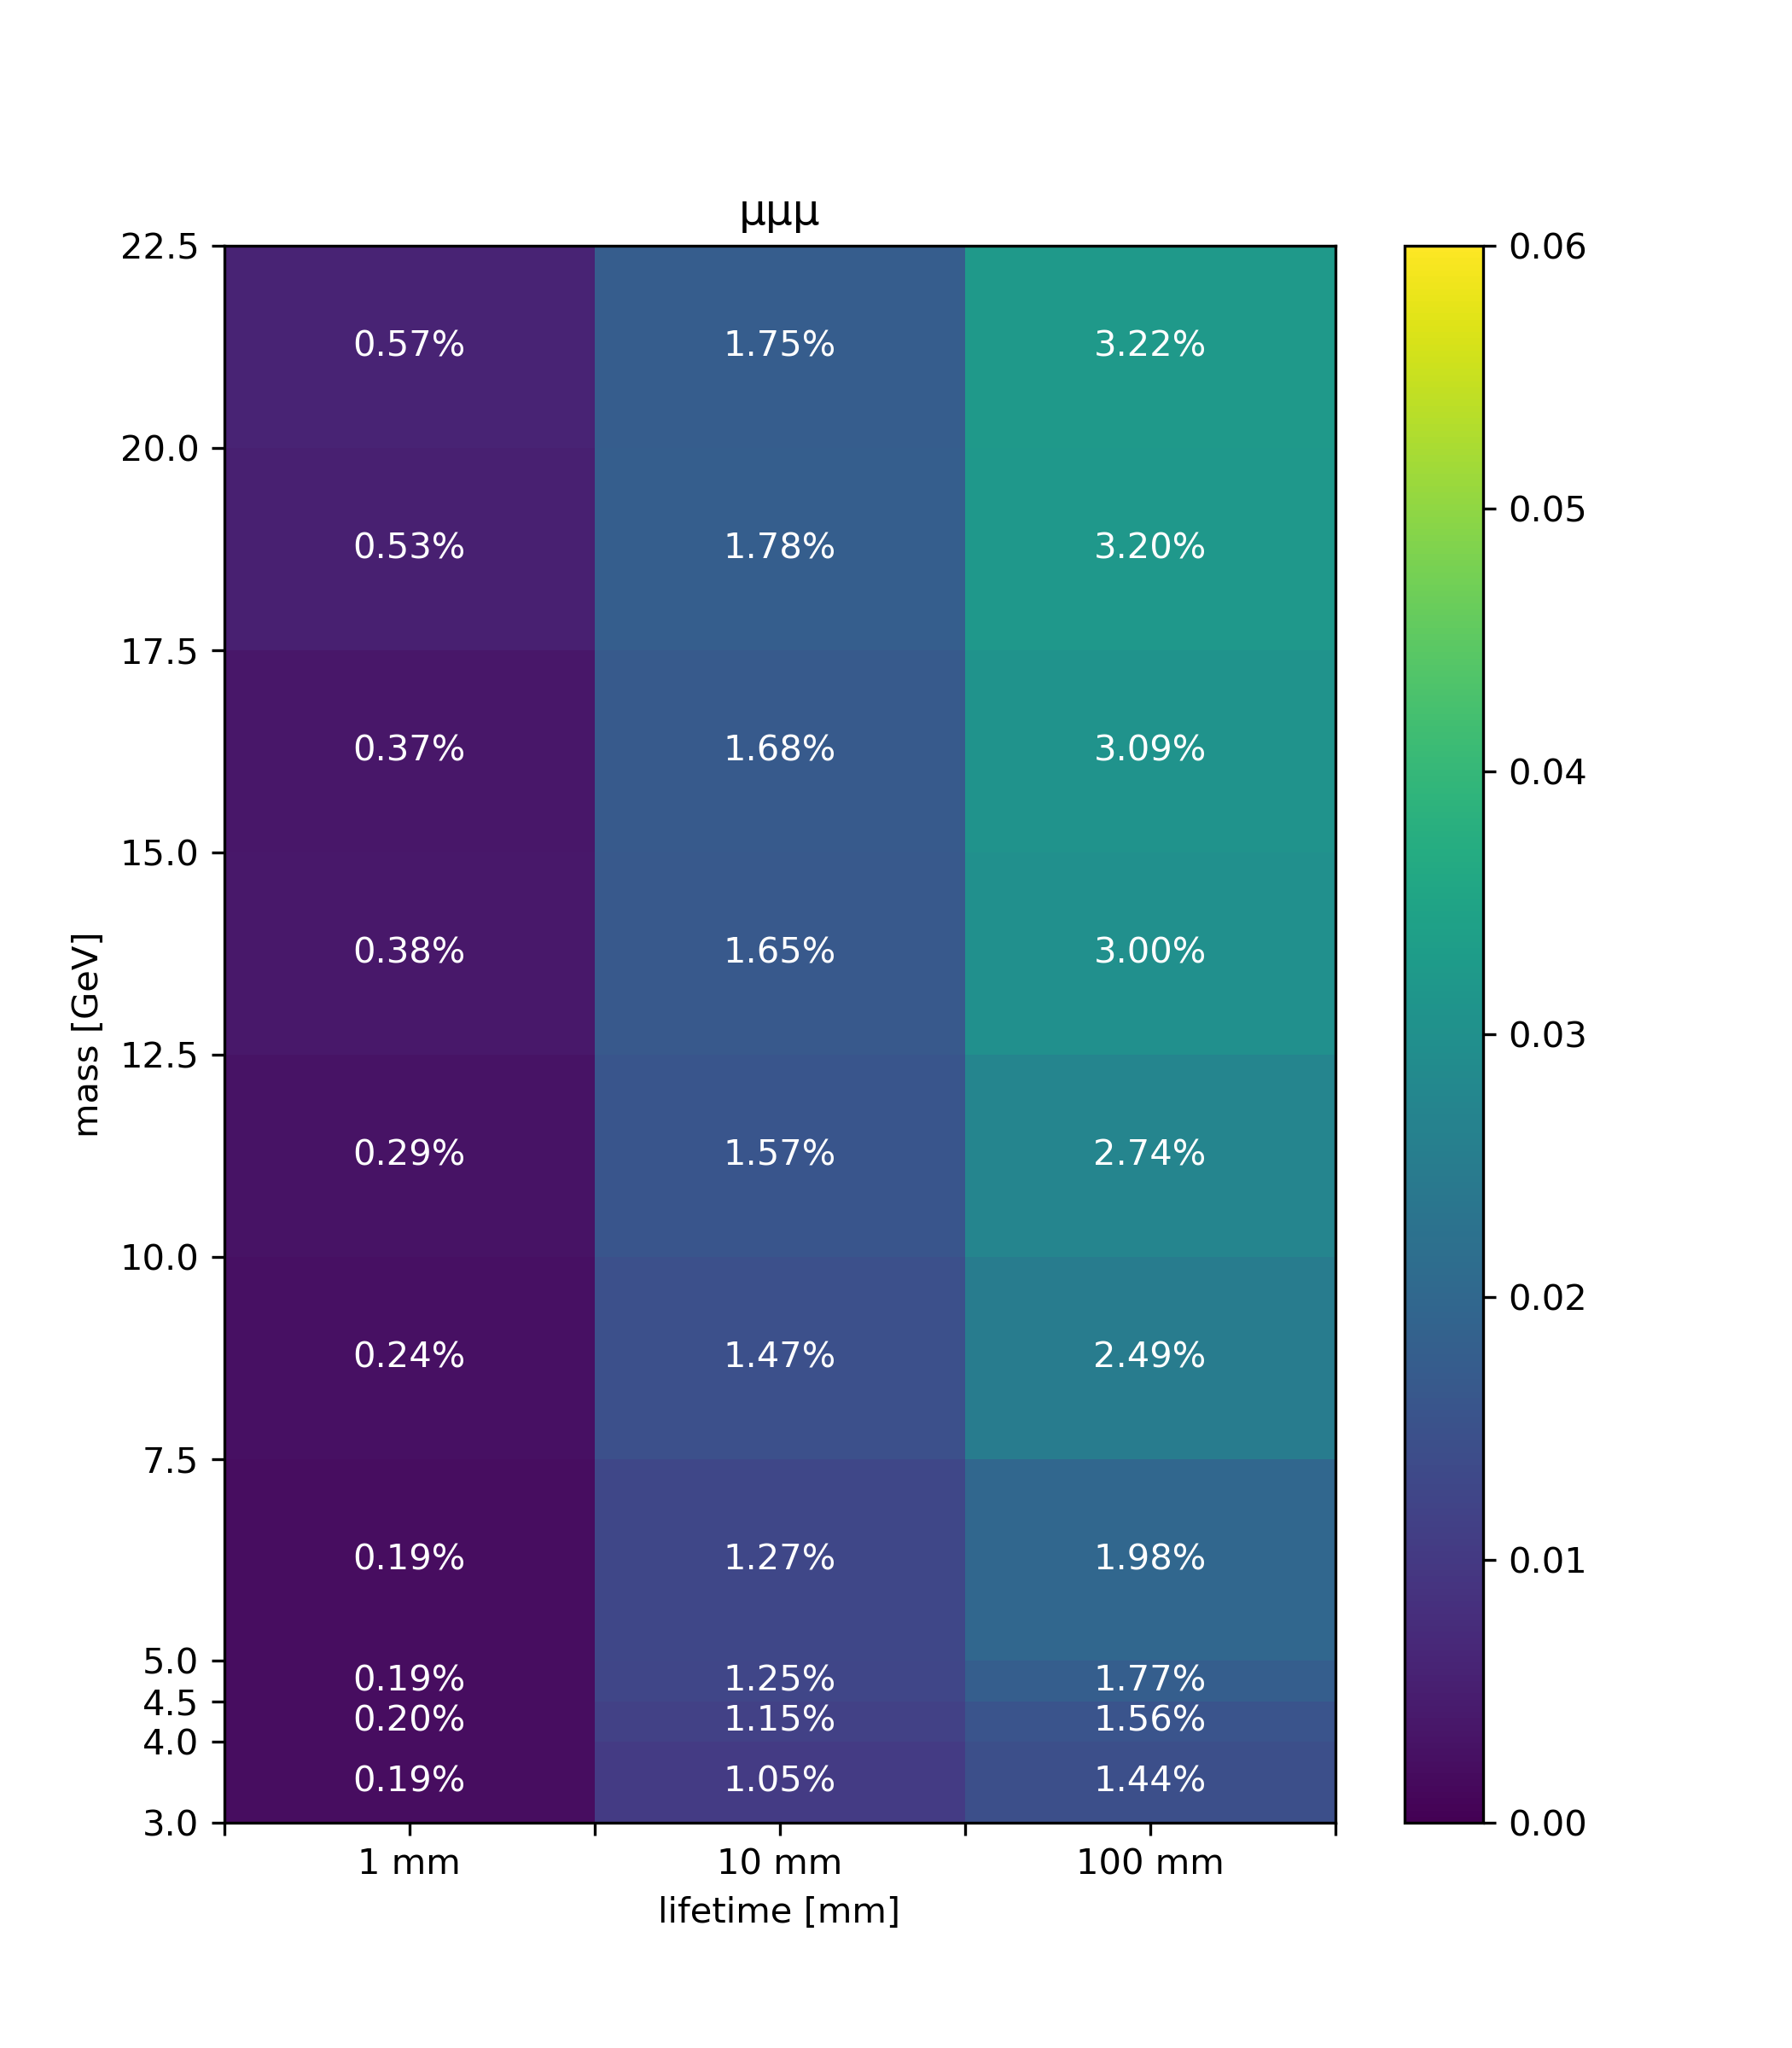

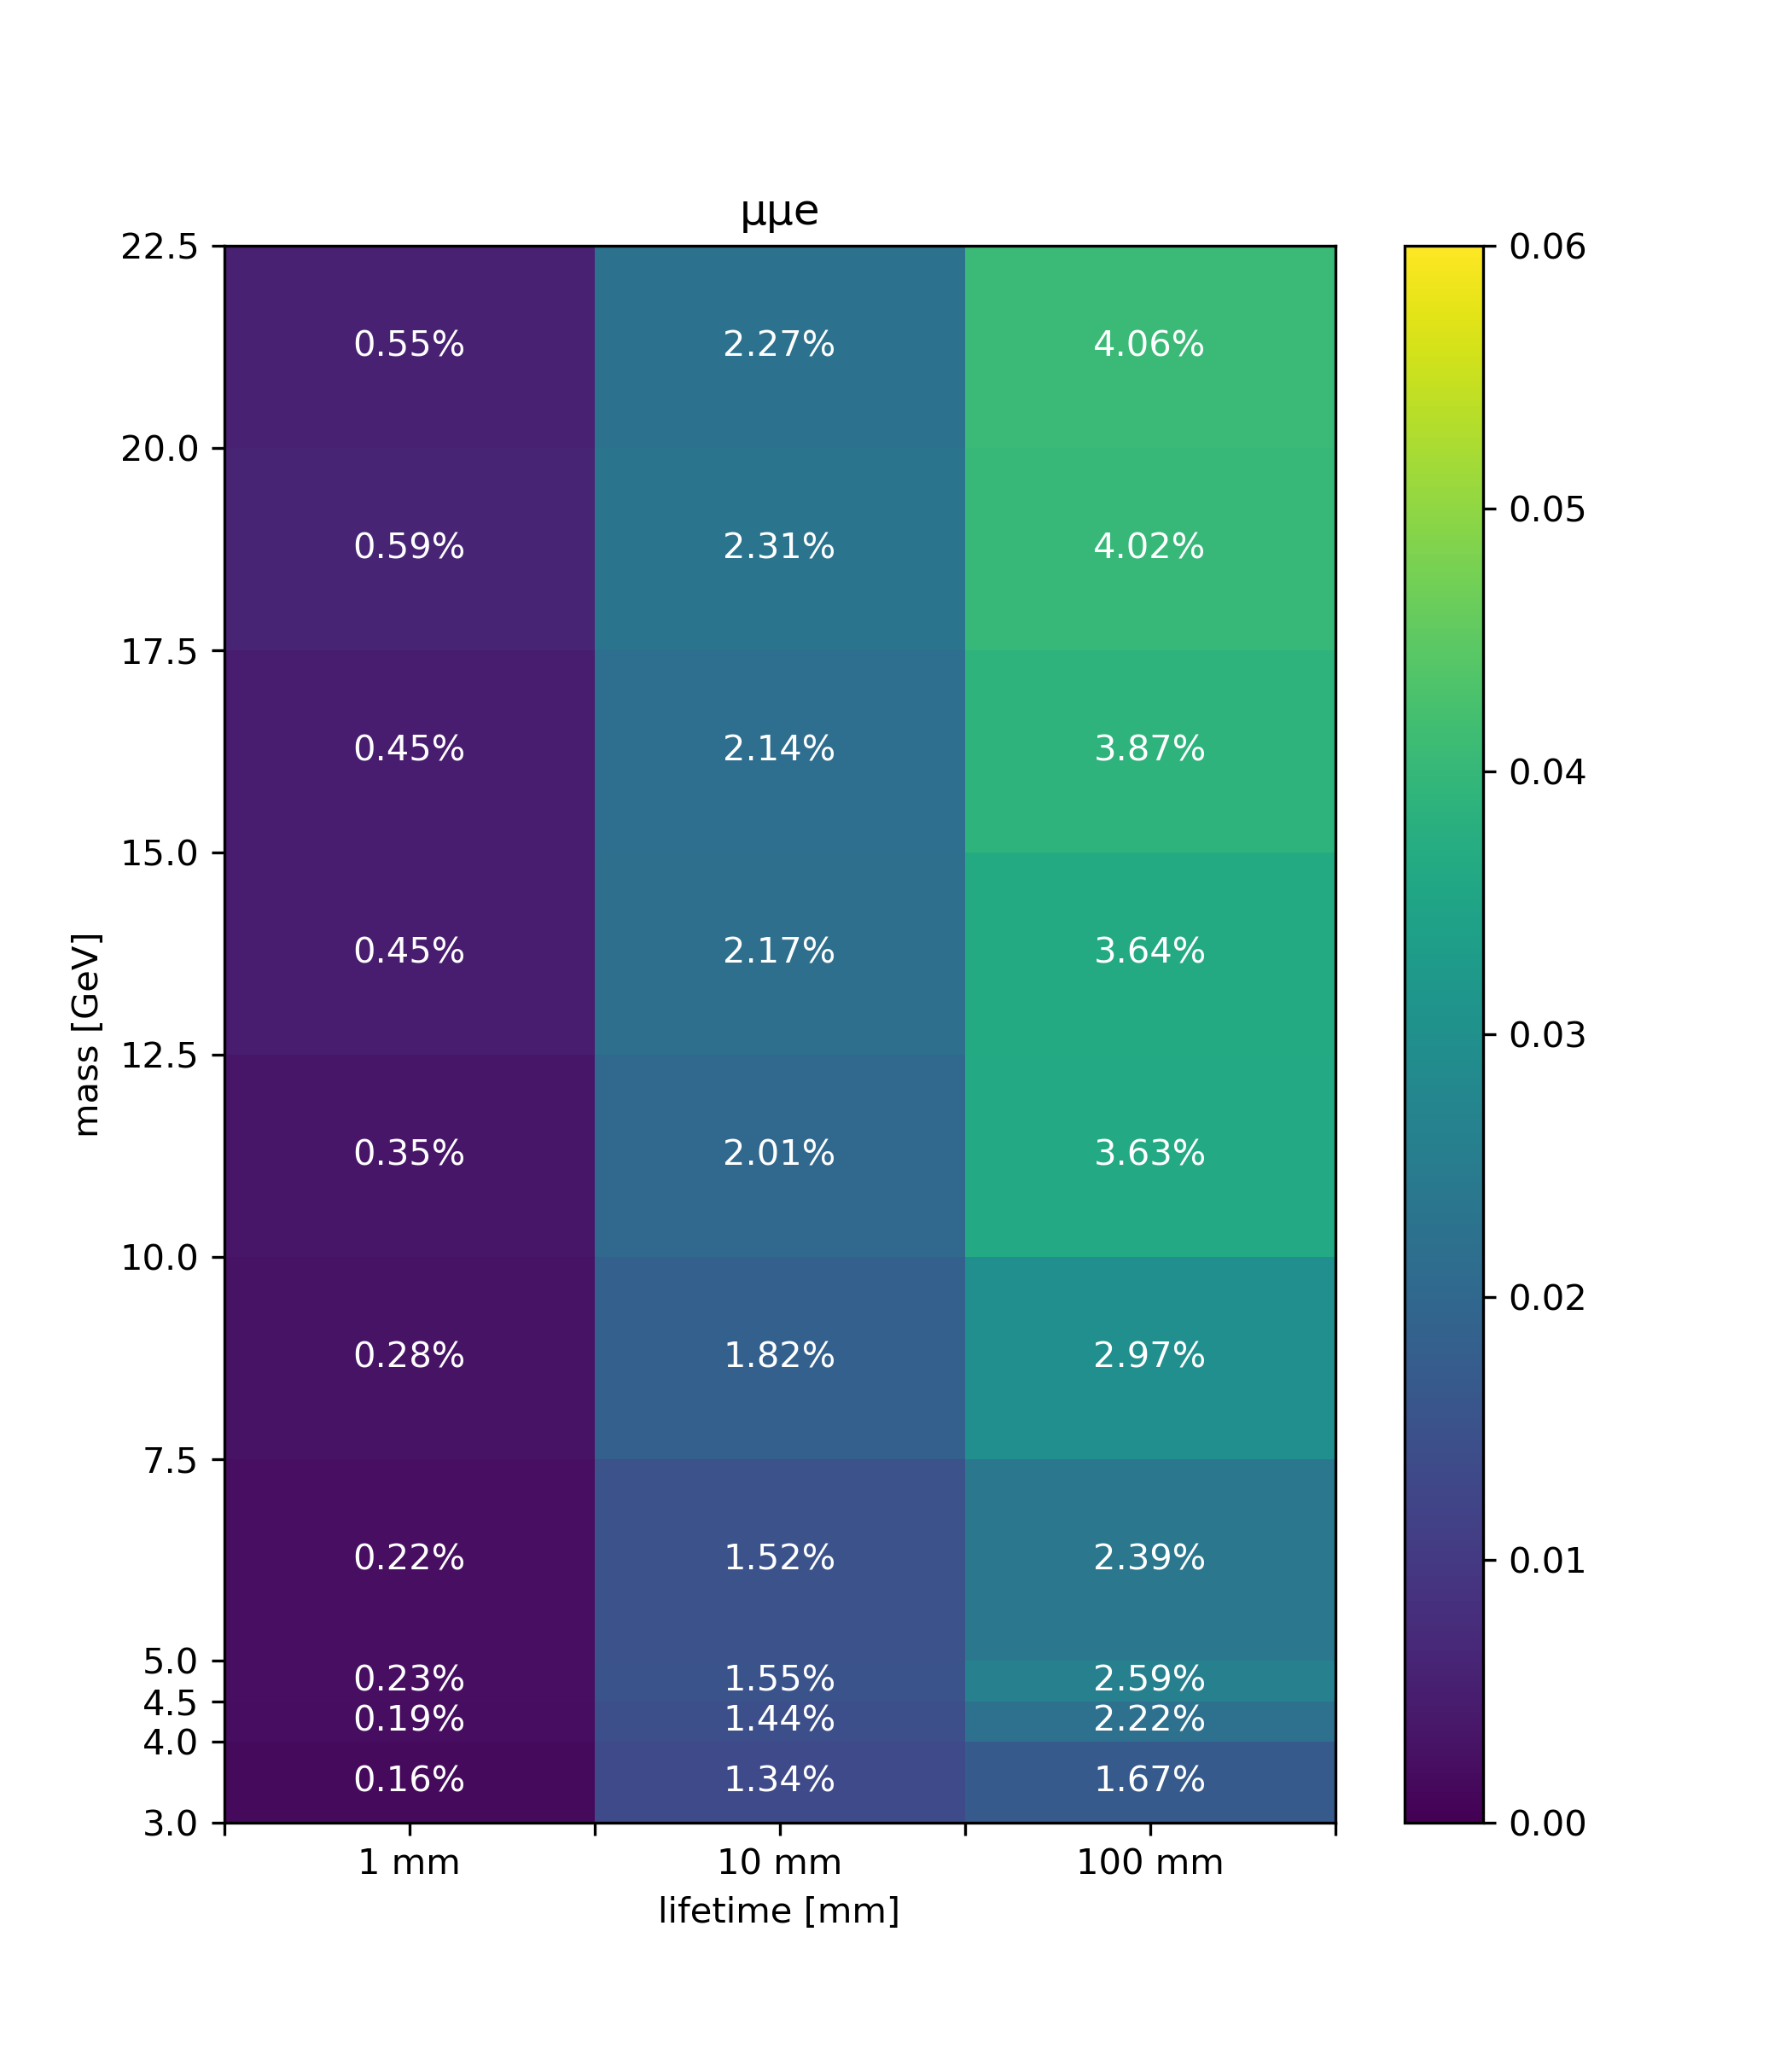

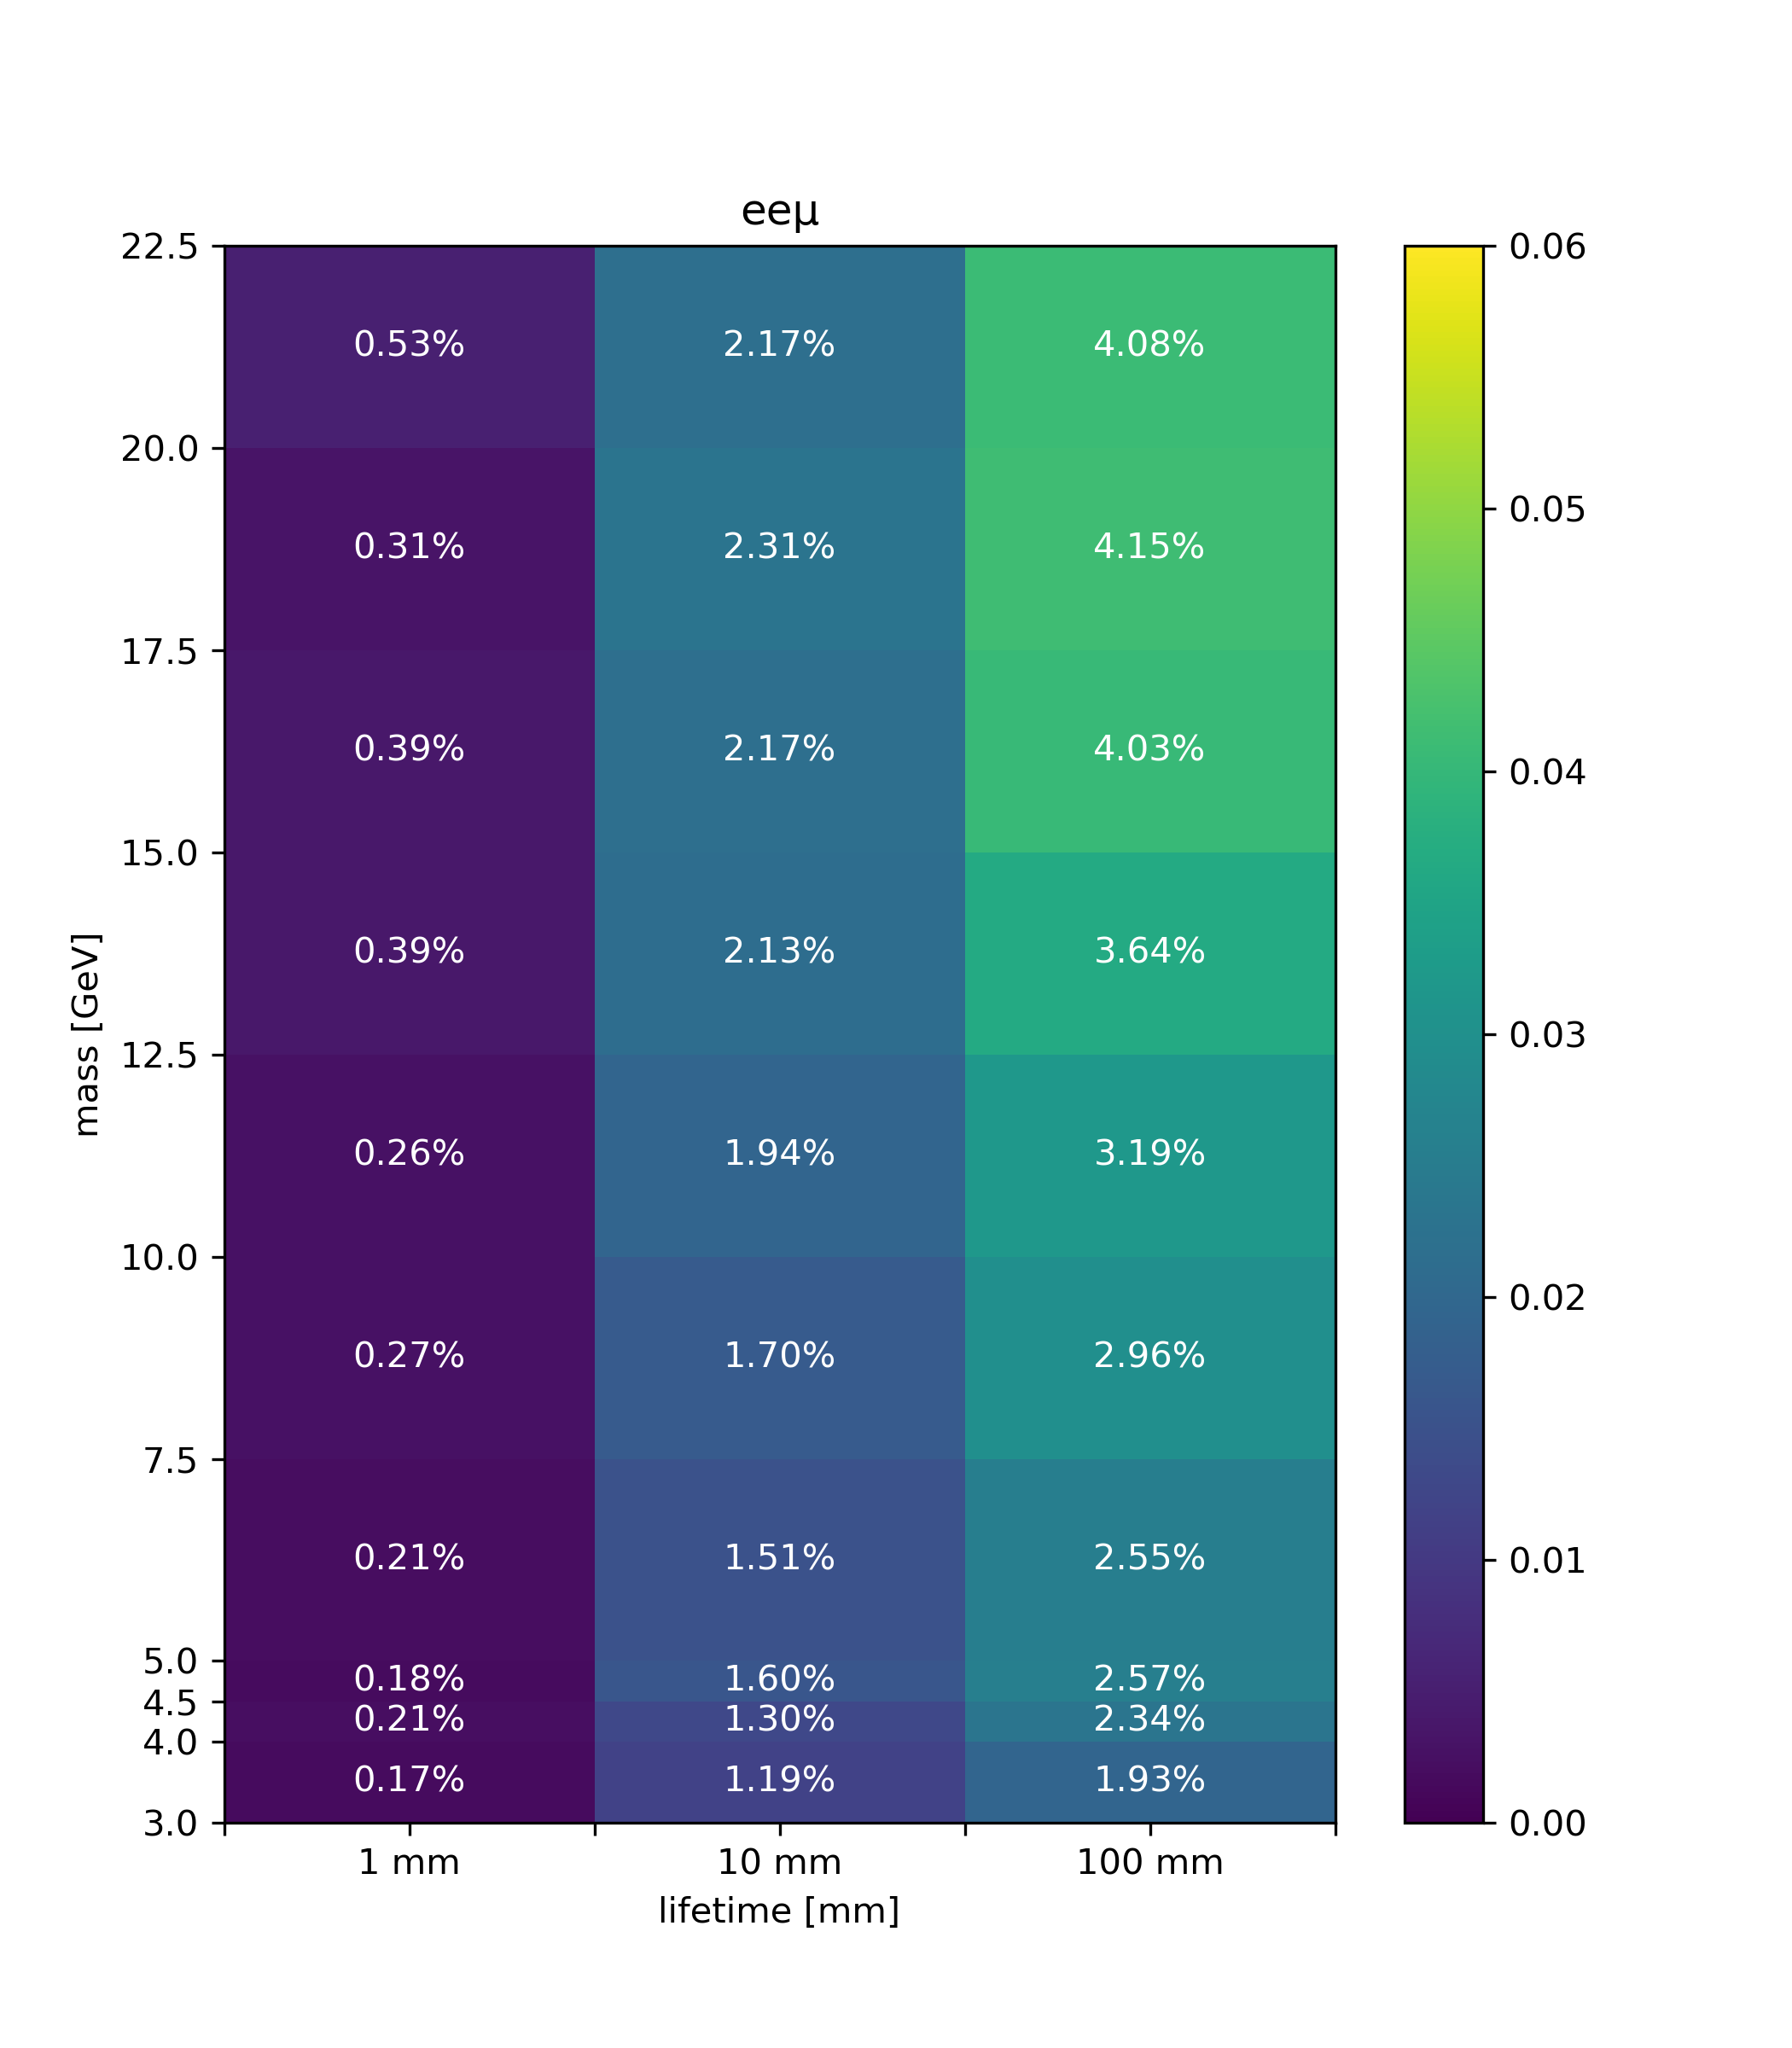

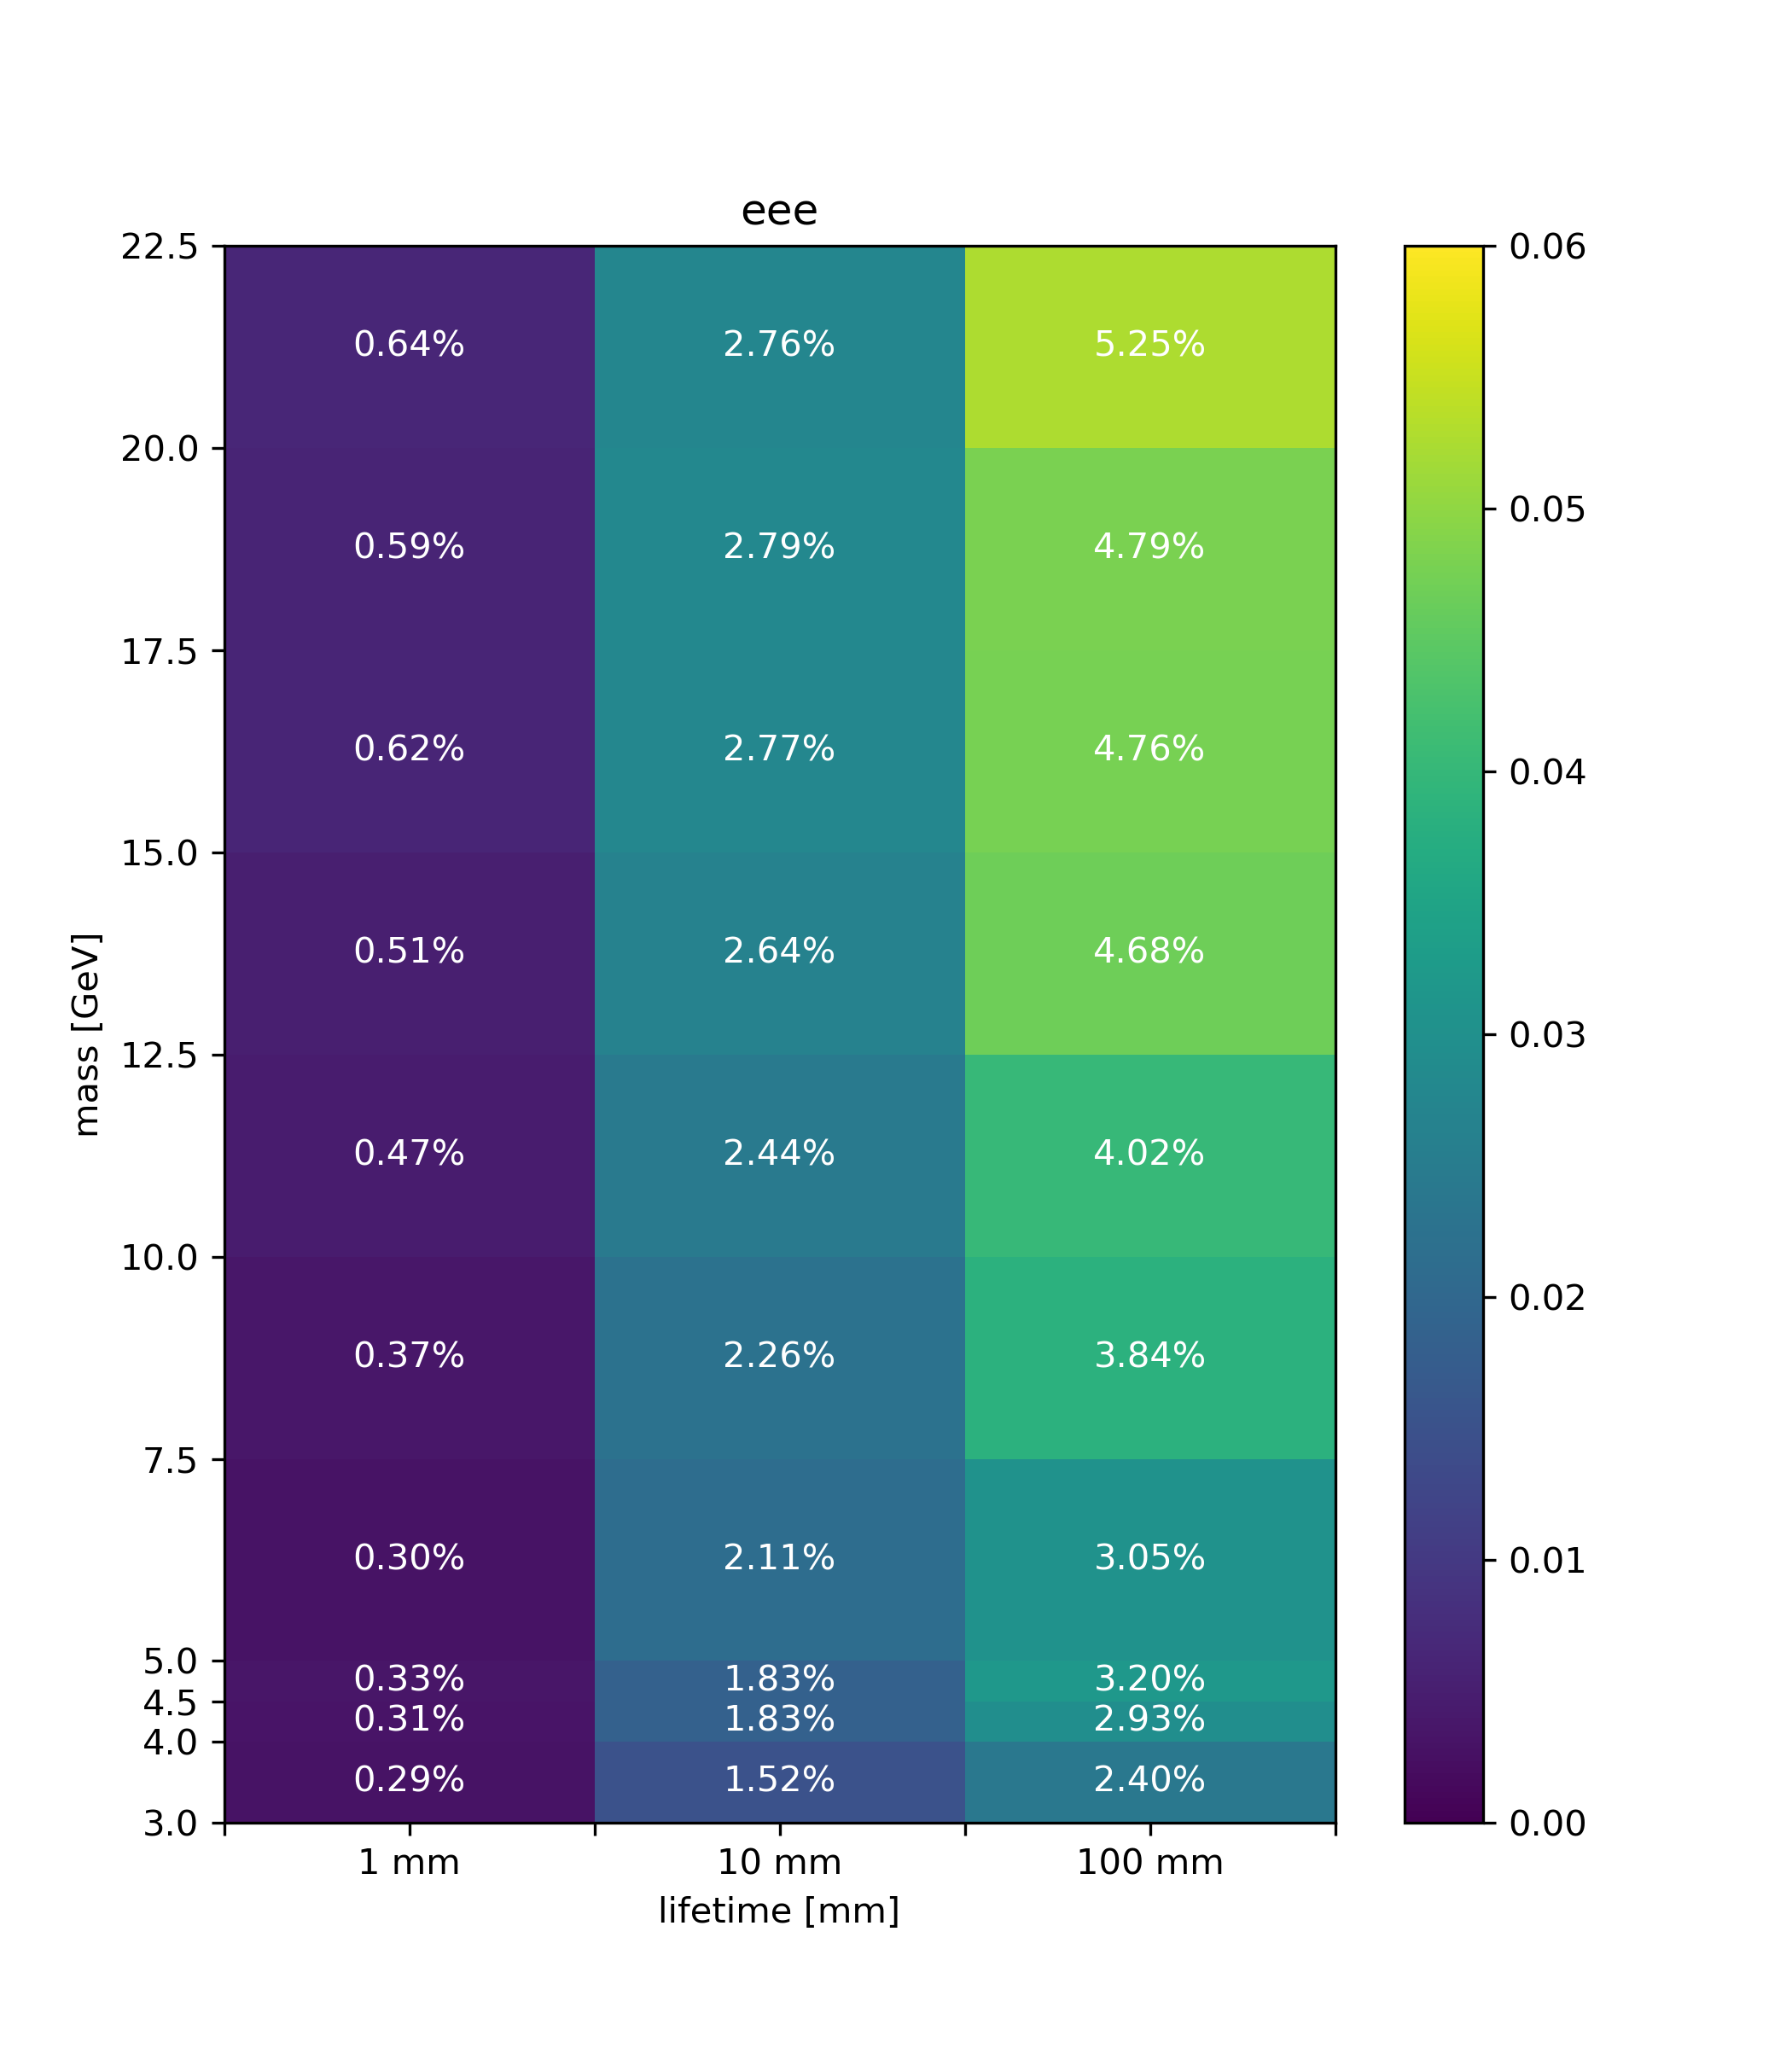

In [26]:
import uproot
import pandas as pd
import matplotlib.pyplot as plt


masses = [3, 4, 4.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5]
lifetimes = {1:0, 10:1, 100:2}

def set_bin_content(mass, lifetime, value, arr):
    ybin = np.max(np.digitize(mass, masses)-1, 0)
    xbin = lifetimes[lifetime]
    arr[ybin,xbin] = value

def make_uncertainty_plot(histpath, title, outfile):

    uncertianty_arr = np.array([
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    ])

    # get bins from ntuples    
    for hist_file in glob.glob(histpath):
        # cutflow_dict_a, cutflow_dict_b = make_cutflows(hist_file, hist_file.replace('4p0','4p1'))
        # diff_mdv = (cutflow_dict_a['m_{DV}'] - cutflow_dict_b['m_{DV}'])/ cutflow_dict_a['m_{DV}']
        f = uproot.open(hist_file)
        df = pd.concat([
        f['VSI_LeptonsMod_ntuples_LNV_DVtype'].pandas.df(['displaced_lepton_uncertainty']),
        f['VSI_LeptonsMod_ntuples_LNC_DVtype'].pandas.df(['displaced_lepton_uncertainty']),
        ])
        displaced_lepton_uncertainty = 1-df['displaced_lepton_uncertainty'].mean()
        # displaced_lepton_uncertainty = .5

        tokens = hist_file.split('/')[5].split('_')
        file_lifetime = int(tokens[4].split('mm')[0])
        file_mass = float(tokens[3][:-1].replace('p','.'))
        set_bin_content(file_mass, file_lifetime, displaced_lepton_uncertainty, uncertianty_arr)
        # set_bin_content(5, 1, mean, uncertianty_arr)

    # do the plotting
    plot_uncertainties(uncertianty_arr, title, outfile)
    return uncertianty_arr

def plot_uncertainties(uncertianty_arr, title, outfile):
    plt.figure(figsize=[7,8])
    plt.pcolormesh([0,1,2,3], masses, uncertianty_arr, vmin=0, vmax=.06)
    plt.colorbar()
    ax = plt.gca()
    ax.set_xticklabels(['','1 mm', '', '10 mm', '', '100 mm',])
    ax.set_yticks(masses)
    ax.set_title(title)
    ax.set_xlabel('lifetime [mm]')
    ax.set_ylabel('mass [GeV]')

    # set text
    for i in range(len(masses)-1):
        for j in range(len(lifetimes)):
            yloc = j+.5
            xloc = masses[i] + (masses[i+1]-masses[i])/2 
            text = ax.text(yloc, xloc , f'{uncertianty_arr[i,j]*100:0.2f}%',
                            ha="center", va="center", color="w", transform=ax.transData)
    plt.savefig('/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/displaced_lepton/plots/'+outfile+'.png', dpi=300)

make_uncertainty_plot(histpath='/data/hnl/histograms/v5p0_histograms/histograms_mc16e_uuu_*', title='μμμ', outfile='uuu_displaced_lepton_systematic')
display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/displaced_lepton/plots/uuu_displaced_lepton_systematic.png'));
make_uncertainty_plot(histpath='/data/hnl/histograms/v5p0_histograms/histograms_mc16e_uue_*', title='μμe', outfile='uue_displaced_lepton_systematic')
display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/displaced_lepton/plots/uue_displaced_lepton_systematic.png'));
make_uncertainty_plot(histpath='/data/hnl/histograms/v5p0_histograms/histograms_mc16e_eeu_*', title='eeμ', outfile='eeu_displaced_lepton_systematic')
display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/displaced_lepton/plots/eeu_displaced_lepton_systematic.png'));
make_uncertainty_plot(histpath='/data/hnl/histograms/v5p0_histograms/histograms_mc16e_eee_*', title='eee', outfile='eee_displaced_lepton_systematic')
display(Image(filename=f'/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/systematics/displaced_lepton/plots/eee_displaced_lepton_systematic.png'));
